In [3]:
import pandas as pd
import numpy as np
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer

import re
import optuna

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
import warnings; warnings.simplefilter('ignore')

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier

# READ DATA

In [4]:
# Read the data
classified_data = pd.read_csv("final_data.csv",  sep=';')
classified_data.replace([np.inf, -np.inf], np.nan, inplace=True)
classified_data = classified_data.dropna()
classified_data.avis1 = classified_data.avis1.astype(int)

In [5]:
classified_data

,avis1,text,id
0,1,Elle ne devait pas dégager la nazi ??? https:/...,1.466478e+18
1,0,je dois faire un oral en anglais sur Hitler et...,1.466478e+18
2,0,@ambrassmoi_ A ça 🤏 de ressembler à la croix n...,1.466478e+18
3,0,"Par curiosité, j’ai voulu écouter les discours...",1.466478e+18
4,1,@tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...,1.466478e+18
...,...,...,...
2851,1,Kevin c’est un sal noir.,1.464411e+18
2852,1,"bougnoule bamboula sale arabe , elle est belle...",1.464364e+18
2853,1,@B_mahrezz Tu viens de le traiter de sal noir ?,1.464234e+18
2854,1,SAL NOIR https://t.co/JraABFtel8,1.463961e+18


In [6]:
classified_data['avis1'].value_counts()

0    1851
1    1005
Name: avis1, dtype: int64

# DATA CLEAN 

In [7]:
# all the tweets
text = list(classified_data['text'])

In [8]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

In [9]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+"," ",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", " ", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", " ").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = re.sub(r'[^\w\s]',' ',tweet)
    final_tweet = emoji_pattern.sub(r'', tweet) #Remove all emojis
    return final_tweet

In [10]:
map_object = map(cleaner, text)
cleaned_text = list(map_object)
final_text = list(map(lambda x: x.lower(), cleaned_text))

In [11]:
final_df = pd.DataFrame(final_text, columns=["Cleaned Tweets"])
classements = classified_data['avis1']
final_df['Classement'] = classements
final_df

,Cleaned Tweets,Classement
0,elle ne devait pas dégager la nazi,1
1,je dois faire un oral en anglais sur hitler et...,0
2,a ça de ressembler à la croix nazi mdrr,0
3,par curiosité j ai voulu écouter les discours...,0
4,mdr deux nazi n importe quoi,1
...,...,...
2851,kevin c est un sal noir,1
2852,bougnoule bamboula sale arabe elle est belle...,1
2853,mahrezz tu viens de le traiter de sal noir,1
2854,sal noir,1


# TFIDF VECTORIZER

In [12]:
import nltk
from  nltk.stem.snowball import FrenchStemmer

def generate_stopwords():
    stopwords_fr = nltk.corpus.stopwords.words("french")
    stop_words = stopwords_fr
    other_exclusions = ["les"]
    stop_words.extend(other_exclusions)
    return stop_words

In [13]:
# Treatment on the first tweets
vectorizer = TfidfVectorizer(stop_words=generate_stopwords())
B = vectorizer.fit_transform(final_text)
list_of_words = vectorizer.get_feature_names_out()

In [14]:
B.shape

(2856, 10138)

In [15]:
# prepare the X matrix for the models
bool_X = B.A > 0
final_X = bool_X.astype(int)
final_X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
X = pd.DataFrame(final_X, columns=list_of_words)
X

,00,000,001,008,0311,058,06,07h,0ff,10,...,être,êtres,êxtreme,île,ïse,œil,œillères,œuf,œuvre,œuvres
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
y = final_df["Classement"]

In [18]:
# Split Data to train and test parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Random Forest**

### *Model*

In [17]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

### *Prediction*

In [18]:
y_pred = random_forest_model.predict(X_test)

### *Some metrics*

In [19]:
print("Accuracy:", accuracy_score(y_test,y_pred))

Accuracy: 0.7762237762237763


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       375
           1       0.69      0.63      0.66       197

    accuracy                           0.78       572
   macro avg       0.75      0.74      0.75       572
weighted avg       0.77      0.78      0.77       572



### *Confusion Matrix*

In [21]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred).ravel())
# TN FP FN TP

Confusion Matrix:
[319  56  72 125]


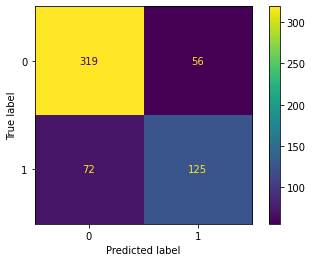

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(random_forest_model, X_test, y_test)

## **Logistic Regression**

In [19]:
logistic_regression_model = LogisticRegression().fit(X_train, y_train)

In [20]:
logistic_regression_model.score(X_test, y_test)

0.7937062937062938

In [21]:
y_pred_LR = logistic_regression_model.predict(X_test)

In [22]:
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       375
           1       0.72      0.65      0.68       197

    accuracy                           0.79       572
   macro avg       0.77      0.76      0.77       572
weighted avg       0.79      0.79      0.79       572



In [23]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_LR).ravel())
# TN FP FN TP

Confusion Matrix:
[326  49  69 128]


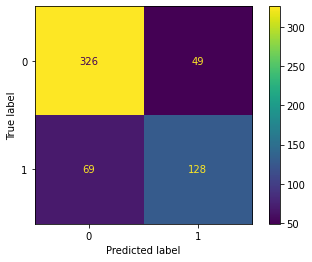

In [24]:
plot_confusion_matrix(logistic_regression_model, X_test, y_test)

## Some explanations about Best model

In [25]:
test_df = final_df.tail(572)
test_df["Predicition_LR"] = y_pred_LR
test_df

,Cleaned Tweets,Classement,Predicition_LR
2284,je suis crevé,0,0
2285,c est une criminelle à la hauteur d adolf hitl...,1,0
2286,au nazi surtout un délice,0,0
2287,il a tout à fait raison ils viennent be tr...,0,1
2288,premier anime dragon ball dernier anime vi...,0,0
...,...,...,...
2851,kevin c est un sal noir,1,1
2852,bougnoule bamboula sale arabe elle est belle...,1,1
2853,mahrezz tu viens de le traiter de sal noir,1,0
2854,sal noir,1,0


In [26]:
TN_df = test_df.loc[test_df["Classement"]==1]
TN_df = TN_df.loc[TN_df["Predicition_LR"]==0]
TN_df

,Cleaned Tweets,Classement,Predicition_LR
2285,c est une criminelle à la hauteur d adolf hitl...,1,0
2290,purée mais les gens reveillez vous ces phra...,1,0
2292,hamdullilah non merci le negro est riche comm...,1,0
2300,je rassure je ne suis ni de droite ni de gauch...,1,0
2301,je suis allé voir son profil il manque que la...,1,0
...,...,...,...
2848,chacun son tour vous vous faites aider par le...,1,0
2849,il va parler de manchester ce sal noir je suis...,1,0
2853,mahrezz tu viens de le traiter de sal noir,1,0
2854,sal noir,1,0


In [31]:
TN_df.to_csv('true_negative_df.csv')

In [27]:
FN_df = test_df.loc[test_df["Classement"]==0]
FN_df = FN_df.loc[FN_df["Predicition_LR"]==1]
FN_df

,Cleaned Tweets,Classement,Predicition_LR
2287,il a tout à fait raison ils viennent be tr...,0,1
2289,genre la secu ou la sncf les congés payées ...,0,1
2299,tu évites d invoquer hitler ou un autre cinglé...,0,1
2305,j aime trop le military lolita mais j ai peur ...,0,1
2307,fidele elle a dit c est qui ce negro,0,1
...,...,...,...
2791,après c est normal qu on vous bride un peu vou...,0,1
2801,ok j ai défendu manel maintenant je dois faire...,0,1
2803,j frai jamais de trêve et tant pis si j en crève,0,1
2806,18h17 c est le moment parfait pour que les cli...,0,1


In [28]:
FN_df.to_csv('false_negative_df.csv')

## **XGBOOST**

In [32]:
xgboost_model = GradientBoostingClassifier().fit(X_train, y_train)

In [33]:
y_pred_XB = xgboost_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test,y_pred_XB))

Accuracy: 0.7867132867132867


In [34]:
print(classification_report(y_test, y_pred_XB))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       375
           1       0.71      0.64      0.67       197

    accuracy                           0.79       572
   macro avg       0.77      0.75      0.76       572
weighted avg       0.78      0.79      0.78       572



In [35]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_XB).ravel())
# TN FP FN TP

Confusion Matrix:
[324  51  71 126]


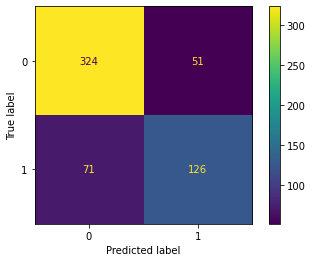

In [36]:
plot_confusion_matrix(xgboost_model, X_test, y_test)